# DSLabs functions

In [1]:
%run "scripts/dslabs_functions.py"


# Data functions

In [2]:
%run "scripts/data_functions.py"

import pandas as pd
import numpy as np



data_functions lodaded


# Load

In [3]:
test_data=False
# test_data=False


file_tag = "Gira Bike"


train=pd.read_csv(f"data/df_gira_agg_2h_final_train.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"data/df_gira_agg_2h_final_test.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
target='target_station_load_rate'
# Se os dados já tiverem a frequência correta para cada dia (com todas as horas), 
# podemos apenas ajustar o índice para começar no horário correto.
#
#train.index = pd.date_range(start='2022-01-01 14:00', periods=len(train), freq='2H')
#test.index = pd.date_range(start='2023-02-14 16:00', periods=len(test), freq='2H')



test_split_threshold=0.9
# Prepare the training and testing data from dataframes with features and target
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]


from numpy import arange

# Ensure no data leakage
assert not set(train.index).intersection(set(test.index)), "Data leakage detected: Train and test sets overlap."


train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4878 entries, 2022-01-01 14:00:00 to 2023-02-14 14:00:00
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   temperature_2m                                               4878 non-null   float64
 1   rain_mm                                                      4878 non-null   float64
 2   wmo_weather_code                                             4878 non-null   float64
 3   wind_speed_10m                                               4878 non-null   float64
 4   is_holiday_lisbon                                            4878 non-null   float64
 5   target_station_status                                        4878 non-null   float64
 6   target_station_load_rate                                     4878 non-null   float64
 7   station_load_rate_ Rua do Arco Cego / Av. 

# ARIMA Univariate

## ARIMA Study

ARIMA (5, 1, 5) failed: LU decomposition error.
ARIMA best results achieved with (p,d,q)=(5, 0, 7) ==> measure=0.02


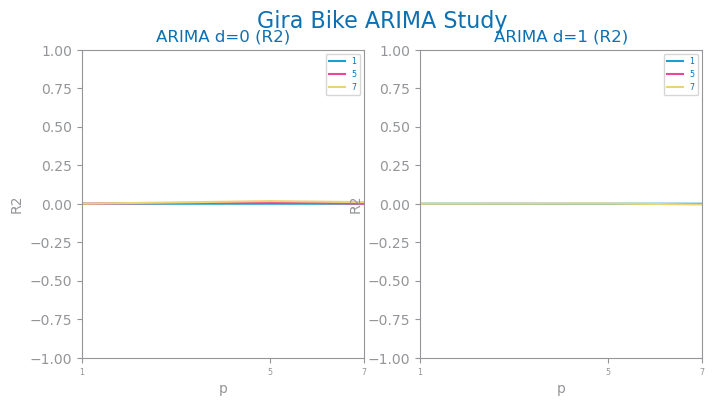

In [12]:


measure = 'R2'

best_model, best_params = arima_uni_study(trnY, trnY, measure=measure)#, freq = '2H')
savefig(f"images/{file_tag}_arima_univariate_{measure}_study.png")

Testando ARIMA(1, 0, 1)...
Testando ARIMA(5, 0, 1)...
Testando ARIMA(7, 0, 1)...
Testando ARIMA(1, 0, 5)...
Testando ARIMA(5, 0, 5)...
Testando ARIMA(7, 0, 5)...
Testando ARIMA(1, 0, 7)...
Testando ARIMA(5, 0, 7)...
Testando ARIMA(7, 0, 7)...
Testando ARIMA(1, 1, 1)...
Testando ARIMA(5, 1, 1)...
Testando ARIMA(7, 1, 1)...
Testando ARIMA(1, 1, 5)...
Skipping ARIMA(5, 1, 5)
Testando ARIMA(7, 1, 5)...
Testando ARIMA(1, 1, 7)...
Testando ARIMA(5, 1, 7)...
Testando ARIMA(7, 1, 7)...
Best params encontrados: {'name': 'ARIMA', 'metric': 'R2', 'params': (5, 0, 7)}


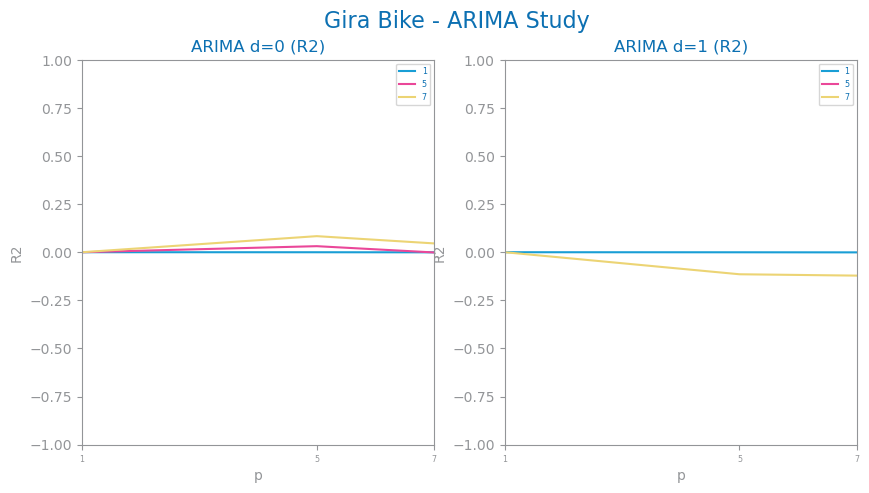

In [26]:
from matplotlib.pyplot import figure, savefig, subplots
import warnings
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import Series
from numpy import isfinite, nan
from statsmodels.tsa.arima.model import ARIMA

def arima_uni_study(train: Series, test: Series, measure: str = "R2", freq: str = None):
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train)]
    test = test[isfinite(test)]

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq)
        test = test.asfreq(freq)

    d_values = [0,1]  # Lista para garantir indexação correta em axs
    p_params = (1, 5, 7)
    q_params = (1, 5, 7)

    # Evitar testar a combinação (5,1,5)
    forbidden_combination = (5, 1, 5)

    flag = measure in ["R2", "MAPE"]
    best_model = None
    best_params = {"name": "ARIMA", "metric": measure, "params": None}
    best_performance = -float("inf")  # Define um valor inicial baixo

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * 5, 5))
    fig.suptitle(f"{file_tag} - ARIMA Study", fontsize=16)  # Add subtitle over the charts      

    if len(d_values) == 1:
        axs = [axs]  # Garantir que axs é sempre uma lista

    for i, d in enumerate(d_values):
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                if (p, d, q) == forbidden_combination:
                    print(f"Skipping ARIMA({p}, {d}, {q})")
                    yvalues.append(nan)  # Mantém o tamanho correto
                    continue

                try:
                    print(f"Testando ARIMA({p}, {d}, {q})...")
                    arima = ARIMA(train, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 100})
                    prd_tst = model.forecast(steps=len(test))
                    eval = FORECAST_MEASURES[measure](test, prd_tst)

                    if eval > best_performance:
                        best_performance = eval
                        best_params["params"] = (p, d, q)
                        best_model = model

                    yvalues.append(eval)
                except Exception as e:
                    print(f"ARIMA ({p}, {d}, {q}) falhou: {e}")
                    yvalues.append(nan)  # Garante que a lista mantém o tamanho correto

            values[q] = yvalues

        # Verificar tamanhos antes de chamar plot_multiline_chart
        if len(p_params) == len(yvalues):
            plot_multiline_chart(
                p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})",
                xlabel="p", ylabel=measure, percentage=flag
            )
        else:
            print(f"Erro ao plotar: tamanhos diferentes p_params={len(p_params)}, yvalues={len(yvalues)}")

    print(f"Best params encontrados: {best_params}")
    return best_model, best_params

# Suprimir warnings do Statsmodels
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# Definir a métrica de avaliação
measure = "R2"

# Executar a função e guardar os melhores parâmetros
best_model, best_params = arima_uni_study(trnY, tstY, measure=measure)

# Salvar a imagem do estudo
savefig(f"images/arima_univariate_{measure}_study.png")

# Treinar o modelo final com os melhores parâmetros encontrados
if best_params["params"]:
    predictor = ARIMA(endog=trnY, order=best_params["params"])
    model = predictor.fit()
else:
    print("Nenhuma combinação válida foi encontrada.")


## ARIMA Model Creation

In [24]:
from statsmodels.tsa.arima.model import ARIMA

best_params["params"]

predictor = ARIMA(endog=trnY, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())


                                  SARIMAX Results                                   
Dep. Variable:     target_station_load_rate   No. Observations:                 4878
Model:                       ARIMA(5, 0, 7)   Log Likelihood               -4635.665
Date:                      Mon, 24 Mar 2025   AIC                           9299.331
Time:                              00:02:41   BIC                           9390.226
Sample:                                   0   HQIC                          9331.228
                                     - 4878                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.062e-05      0.001     -0.054      0.957      -0.003       0.003
ar.L1          0.9140      0.072     12.686      0.000       0.773       1.055
ar.L

### Model creation with ext cols lag 1 and lag 12

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

file_tag = "Gira Bike"

# Carregar os dados
train = pd.read_csv(f"data/df_gira_agg_2h_final_train.csv", decimal=".", index_col='date', parse_dates=True)
test = pd.read_csv(f"data/df_gira_agg_2h_final_test.csv", decimal=".", index_col='date', parse_dates=True)

target = 'target_station_load_rate'

# Garantir que não há fuga de dados entre treino e teste
assert not set(train.index).intersection(set(test.index)), "Data leakage detected: Train and test sets overlap."

# Criar variáveis de lag apenas para os lags 1 e 12
for lag in [1, 12]:
    train[f"lag_{lag}"] = train[target].shift(lag)
    test[f"lag_{lag}"] = test[target].shift(lag)

# Remover valores NaN gerados pelos shifts
train = train.dropna()
test = test.dropna()

# Separar variáveis independentes (X) e dependente (Y)
trnX = train[["lag_1", "lag_12"]]  # Apenas os lags desejados
trnY = train[target]
tstX = test[["lag_1", "lag_12"]]
tstY = test[target]

# Criar e treinar o modelo ARIMA usando apenas os lags 1 e 12
predictor = ARIMA(endog=trnY, order=(0, 1, 0), exog=trnX)  # Sem lags internos
model = predictor.fit()

print(model.summary())


In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))
prd_tst.index = test.index

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Univariate ARIMA Evaluate (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_univariate_eval.png")

### ARIMA Model results analysis

Key Findings from the ARIMA Model Summary

- AR (AutoRegressive) Terms:
    - Significant lags: L1 (0.9140), L3 (0.6707), L4 (-0.8300)
    - The strongest positive influence comes from L1 (0.9140) and L3 (0.6707).
    - L4 (-0.8300) has a strong negative impact.

- MA (Moving Average) Terms:
    - Significant lags: L1 (-1.1199), L3 (-0.7191), L4 (0.8788), L7 (-0.2174)
    - L1 (-1.1199) is the most influential (in a negative way), indicating strong correction of past errors.
    - L4 (0.8788) also contributes significantly.

- Constant Term:
    - Close to zero (-7.062e-05), meaning no strong long-term trend in the data.

- Error Variance (sigma²):
    - 0.3897, indicating moderate variability in residuals.

- Model Performance Indicators
    - Log Likelihood: -4635.665
    - AIC (Akaike Information Criterion): 9299.331 (lower is better)
    - BIC (Bayesian Information Criterion): 9390.226 (lower is better)

- Conclusion
    - Lag 1 (AR1 & MA1) has the strongest impact on predictions, with high coefficients in both AR and MA terms.
    - Lags 3 and 4 also play a significant role, showing that past values at these steps influence the current forecast.
    - The model captures strong autoregressive and moving average effects, suggesting a mix of short-term dependencies and error corrections.

## ARIMA Model Plot Diagnostics

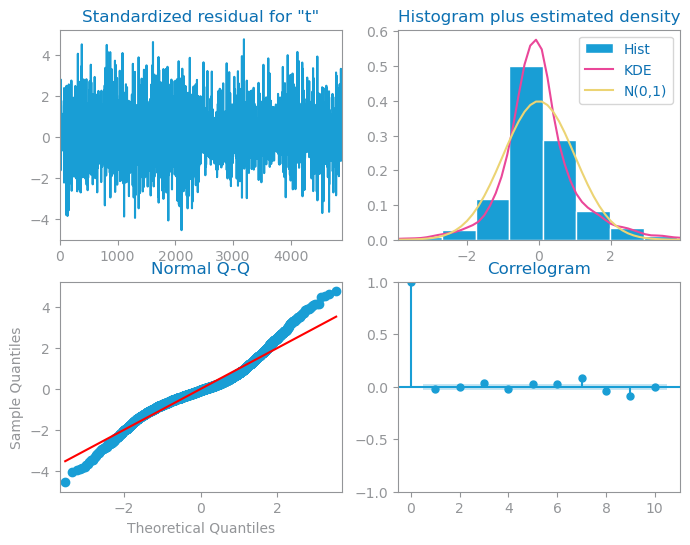

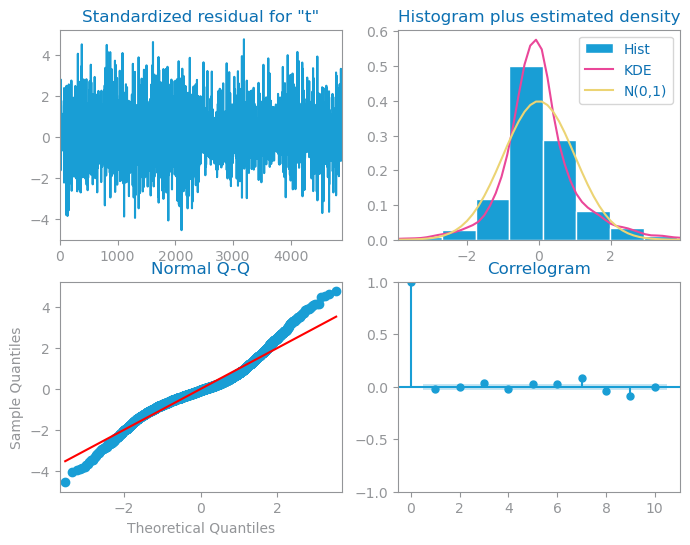

In [27]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Evaluate

In [28]:

def plot_single_model_evaluation(train: Series, test: Series, prd_train: Series, prd_test: Series, title: str = ""):
    # Calculate performance metrics
    metrics = {
        "MAE": [
            mean_absolute_error(train, prd_train),
            mean_absolute_error(test, prd_test),
        ],
        "MSE": [
            mean_squared_error(train, prd_train),
            mean_squared_error(test, prd_test),
        ],
        "RMSE": [
            mean_squared_error(train, prd_train, squared=False),
            mean_squared_error(test, prd_test, squared=False),
        ],
        "R²": [
            r2_score(train, prd_train),
            r2_score(test, prd_test),
        ]
    }

    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics, index=["Train", "Test"]).T
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    scale_dependent_data = performance_df.loc[scale_dependent_errors]
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_errors = ["R²"]
    percentage_data = performance_df.loc[percentage_errors]
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_performance_metrics(metrics: dict, title: str = ""):
    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics)
    
    # Separate scale-dependent errors and percentage errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    percentage_errors = ["R²"]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_data = performance_df[["Model"] + scale_dependent_errors].set_index("Model").T
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_data = performance_df[["Model"] + percentage_errors].set_index("Model").T
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

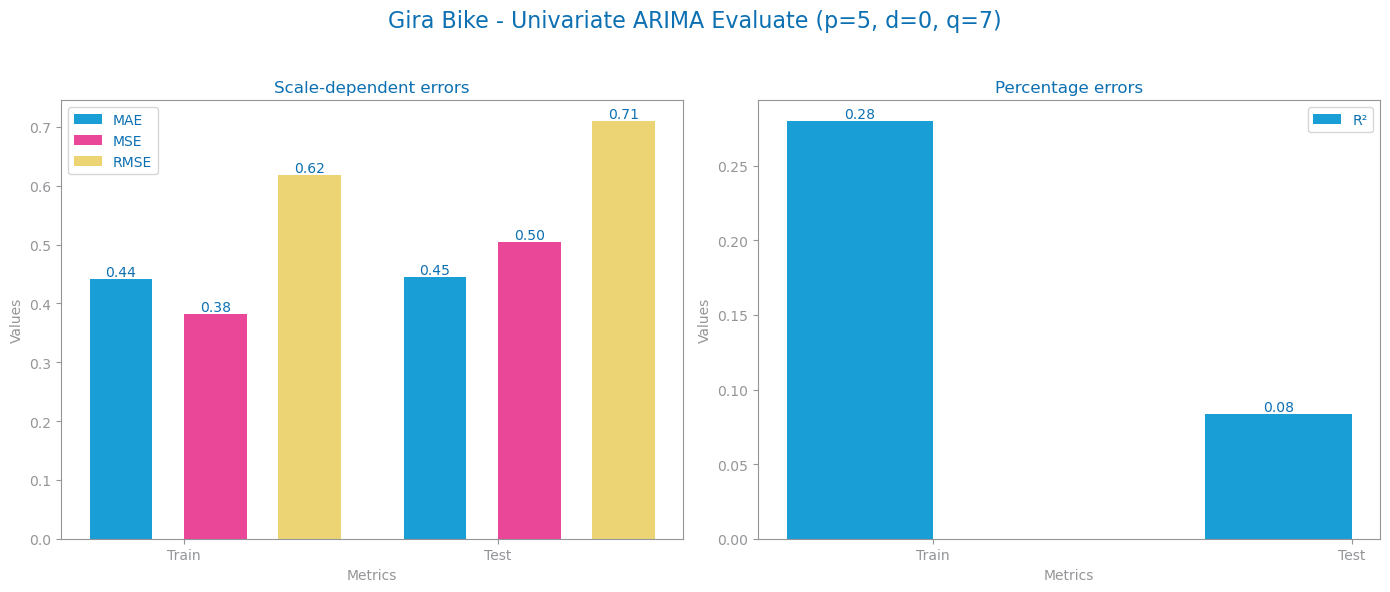

<Figure size 640x480 with 0 Axes>

In [29]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))
prd_tst.index = test.index

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Univariate ARIMA Evaluate (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_univariate_eval.png")

## ARIMA Plot

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

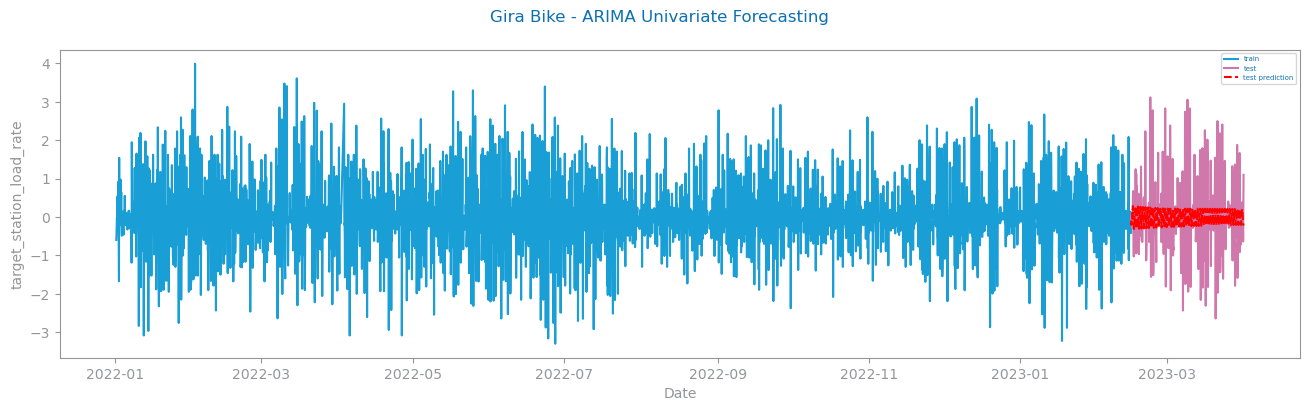

In [31]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)

## Analysis - Results from Model Implementation

# SARIMA Univariate

## SARIMA study

In [145]:
import warnings

# Ignorar todos os avisos (warnings)
warnings.filterwarnings("ignore")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import Series
from numpy import isfinite
from matplotlib.pyplot import savefig, subplots
import sys
import os

# Redirecionar stdout e stderr para ignorar prints
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

def sarima_uni_study(train: Series, test: Series, measure: str = "R2", freq: str = None):
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train)]
    test = test[isfinite(test)]

    if freq:
        train = train.asfreq(freq)
        test = test.asfreq(freq)

    d_values = (0, 1, 2)
    p_params = (1, 3, 5, 7)
    q_params = (1, 3, 5, 7)
    P_params = (0, 1, 2)
    D_values = (0, 1)
    Q_params = (0, 1, 2)
    s = 12  # Seasonal period (24h / 2h = 12)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params = {"name": "SARIMA", "metric": measure, "params": ()}
    best_performance = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * 5, 5))
    fig.suptitle(f"SARIMA Study", fontsize=16)
    
    for i, d in enumerate(d_values):
        values = {}
        for q in q_params:
            for p in p_params:
                try:
                    sarima = SARIMAX(train, order=(p, d, q), seasonal_order=(P_params[0], D_values[0], Q_params[0], s))
                    model = sarima.fit(method_kwargs={"maxiter": 100})
                    prd_tst = model.forecast(steps=len(test))
                    eval_metric = FORECAST_MEASURES[measure](test, prd_tst)
                    
                    # Update the best model if the current one performs better
                    if eval_metric > best_performance and abs(eval_metric - best_performance) > DELTA_IMPROVE:
                        best_performance = eval_metric
                        best_params["params"] = (p, d, q, P_params[0], D_values[0], Q_params[0], s)
                        best_model = model
                    
                except Exception:
                    # Pass silently, no printing on errors
                    pass

    # Print the best results after the loop
    print(f"SARIMA best results: (p,d,q,P,D,Q,s)=({best_params['params']}) ==> measure={best_performance:.2f}")
    
    # Restoring the output to normal (console)
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__

    return best_model, best_params


warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10263D+00    |proj g|=  3.48851D-02

At iterate    5    f=  1.10180D+00    |proj g|=  5.30532D-03

At iterate   10    f=  1.09556D+00    |proj g|=  6.11179D-02


 This problem is unconstrained.



At iterate   15    f=  1.03740D+00    |proj g|=  4.68339D-02

At iterate   20    f=  1.02905D+00    |proj g|=  1.64754D-02

At iterate   25    f=  1.02844D+00    |proj g|=  3.70431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   5.886D-06   1.028D+00
  F =   1.0284345906294154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09423D+00    |proj g|=  1.28736D-02


 This problem is unconstrained.



At iterate    5    f=  1.07771D+00    |proj g|=  1.39264D-01

At iterate   10    f=  1.03285D+00    |proj g|=  6.92269D-02

At iterate   15    f=  1.00541D+00    |proj g|=  1.23919D-02

At iterate   20    f=  1.00079D+00    |proj g|=  3.03947D-03

At iterate   25    f=  1.00073D+00    |proj g|=  5.17819D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     36      1     0     0   5.178D-06   1.001D+00
  F =   1.0007275385448118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.


At iterate    5    f=  1.04673D+00    |proj g|=  1.65531D-01

At iterate   10    f=  9.99644D-01    |proj g|=  2.14740D-02

At iterate   15    f=  9.92794D-01    |proj g|=  1.27481D-02

At iterate   20    f=  9.91079D-01    |proj g|=  3.62064D-03

At iterate   25    f=  9.91057D-01    |proj g|=  9.26936D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     31      1     0     0   9.269D-06   9.911D-01
  F =  0.99105713492828273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10


 This problem is unconstrained.



At iterate    5    f=  9.97644D-01    |proj g|=  1.27895D-01

At iterate   10    f=  9.78406D-01    |proj g|=  1.14122D-02

At iterate   15    f=  9.78017D-01    |proj g|=  7.89439D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     17     20      1     0     0   4.697D-06   9.780D-01
  F =  0.97801722358111276     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.


 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39986D+00    |proj g|=  1.00759D+00

At iterate    5    f=  1.02643D+00    |proj g|=  6.25107D-02

At iterate   10    f=  1.01661D+00    |proj g|=  2.71723D-02

At iterate   15    f=  1.00875D+00    |proj g|=  1.70835D-02

At iterate   20    f=  1.00842D+00    |proj g|=  7.40713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     26      1     0     0   2.940D-06   1.008D+00
  F =   1.0084153119561201     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B 

 This problem is unconstrained.



At iterate    5    f=  1.08005D+00    |proj g|=  1.02805D-01

At iterate   10    f=  1.01967D+00    |proj g|=  4.60060D-02

At iterate   15    f=  1.01506D+00    |proj g|=  3.80753D-02

At iterate   20    f=  1.01360D+00    |proj g|=  8.97977D-03

At iterate   25    f=  1.00469D+00    |proj g|=  3.97503D-02

At iterate   30    f=  1.00135D+00    |proj g|=  1.45021D-01

At iterate   35    f=  9.94979D-01    |proj g|=  1.18782D-02

At iterate   40    f=  9.94698D-01    |proj g|=  6.02877D-03

At iterate   45    f=  9.94670D-01    |proj g|=  2.12937D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     56   

 This problem is unconstrained.



At iterate   15    f=  9.93088D-01    |proj g|=  1.01097D-02

At iterate   20    f=  9.88339D-01    |proj g|=  2.60584D-02

At iterate   25    f=  9.86799D-01    |proj g|=  3.31911D-03

At iterate   30    f=  9.86562D-01    |proj g|=  1.58528D-02

At iterate   35    f=  9.84803D-01    |proj g|=  4.31706D-02

At iterate   40    f=  9.84332D-01    |proj g|=  6.31894D-03

At iterate   45    f=  9.83894D-01    |proj g|=  5.78383D-02

At iterate   50    f=  9.83193D-01    |proj g|=  3.63293D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     71      1     0     0   3.633D-02   9.832D-01
  F =  0.983193047896

 This problem is unconstrained.



At iterate    5    f=  1.01468D+00    |proj g|=  9.51283D-02

At iterate   10    f=  9.91682D-01    |proj g|=  2.78614D-02

At iterate   15    f=  9.89817D-01    |proj g|=  2.63527D-02

At iterate   20    f=  9.86407D-01    |proj g|=  1.89524D-02

At iterate   25    f=  9.85392D-01    |proj g|=  5.16366D-03

At iterate   30    f=  9.85314D-01    |proj g|=  4.40070D-03

At iterate   35    f=  9.84416D-01    |proj g|=  2.09936D-02

At iterate   40    f=  9.83446D-01    |proj g|=  4.45624D-02

At iterate   45    f=  9.82537D-01    |proj g|=  5.11012D-02

At iterate   50    f=  9.81091D-01    |proj g|=  5.50969D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.01877D+00    |proj g|=  8.08786D-02

At iterate   10    f=  9.97213D-01    |proj g|=  1.07984D-02

At iterate   15    f=  9.97059D-01    |proj g|=  5.57561D-04

At iterate   20    f=  9.96908D-01    |proj g|=  1.63287D-02

At iterate   25    f=  9.96842D-01    |proj g|=  8.44106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     36      1     0     0   3.635D-05   9.968D-01
  F =  0.99684237423039690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

 This problem is unconstrained.



At iterate    5    f=  9.99797D-01    |proj g|=  3.79496D-02

At iterate   10    f=  9.73772D-01    |proj g|=  3.20956D-02

At iterate   15    f=  9.71991D-01    |proj g|=  1.08527D-02

At iterate   20    f=  9.70639D-01    |proj g|=  1.74414D-02

At iterate   25    f=  9.68236D-01    |proj g|=  2.29493D-02

At iterate   30    f=  9.68092D-01    |proj g|=  7.39558D-03

At iterate   35    f=  9.68045D-01    |proj g|=  5.55290D-03

At iterate   40    f=  9.67308D-01    |proj g|=  1.75210D-02

At iterate   45    f=  9.65123D-01    |proj g|=  5.10672D-02

At iterate   50    f=  9.59126D-01    |proj g|=  3.37129D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03834D+00    |proj g|=  2.48939D-01

At iterate    5    f=  9.91741D-01    |proj g|=  1.68557D-02

At iterate   10    f=  9.74014D-01    |proj g|=  4.78596D-02

At iterate   15    f=  9.57942D-01    |proj g|=  2.47753D-02

At iterate   20    f=  9.53728D-01    |proj g|=  2.61665D-02

At iterate   25    f=  9.52867D-01    |proj g|=  6.92366D-03

At iterate   30    f=  9.52302D-01    |proj g|=  1.41586D-02

At iterate   35    f=  9.51957D-01    |proj g|=  2.45044D-02

At iterate   40    f=  9.51911D-01    |proj g|=  2.50276D-03

At iterate   45    f=  9.51366D-01    |proj g|=  3.03120D-02

At iterate   50    f=  9.50354D-01    |proj g|=  1.01147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.57758D-01    |proj g|=  5.59929D-02

At iterate   10    f=  9.55846D-01    |proj g|=  1.03939D-02

At iterate   15    f=  9.54822D-01    |proj g|=  2.80330D-02

At iterate   20    f=  9.53801D-01    |proj g|=  1.45741D-02

At iterate   25    f=  9.51936D-01    |proj g|=  1.18237D-02

At iterate   30    f=  9.50465D-01    |proj g|=  2.44326D-02

At iterate   35    f=  9.49785D-01    |proj g|=  1.13133D-03

At iterate   40    f=  9.49774D-01    |proj g|=  8.48365D-04

At iterate   45    f=  9.49758D-01    |proj g|=  4.33129D-04

At iterate   50    f=  9.49757D-01    |proj g|=  4.00126D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.96941D-01    |proj g|=  5.98904D-03

At iterate   10    f=  9.95527D-01    |proj g|=  4.70371D-03

At iterate   15    f=  9.95482D-01    |proj g|=  1.57894D-04

At iterate   20    f=  9.95481D-01    |proj g|=  7.74244D-04

At iterate   25    f=  9.95350D-01    |proj g|=  8.74510D-03

At iterate   30    f=  9.94534D-01    |proj g|=  1.73992D-03

At iterate   35    f=  9.94525D-01    |proj g|=  3.59380D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     39      1     0     0   8.744D-06   9.945D-01
  F =  0.99452500855801251     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.96207D-01    |proj g|=  2.76750D-02

At iterate   10    f=  9.89400D-01    |proj g|=  1.94323D-02

At iterate   15    f=  9.86595D-01    |proj g|=  6.21583D-02

At iterate   20    f=  9.71142D-01    |proj g|=  4.83065D-02

At iterate   25    f=  9.58311D-01    |proj g|=  8.73555D-02

At iterate   30    f=  9.50805D-01    |proj g|=  8.84356D-03

At iterate   35    f=  9.49137D-01    |proj g|=  7.74587D-03

At iterate   40    f=  9.49000D-01    |proj g|=  1.66406D-03

At iterate   45    f=  9.48954D-01    |proj g|=  1.55579D-03

At iterate   50    f=  9.48892D-01    |proj g|=  4.71878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.75463D-01    |proj g|=  5.78440D-02

At iterate   10    f=  9.64965D-01    |proj g|=  6.77920D-02

At iterate   15    f=  9.57228D-01    |proj g|=  5.05655D-03

At iterate   20    f=  9.53747D-01    |proj g|=  3.72003D-02

At iterate   25    f=  9.50013D-01    |proj g|=  6.40312D-02

At iterate   30    f=  9.47407D-01    |proj g|=  4.96131D-02

At iterate   35    f=  9.45506D-01    |proj g|=  1.97557D-02

At iterate   40    f=  9.43224D-01    |proj g|=  5.22905D-02

At iterate   45    f=  9.40696D-01    |proj g|=  6.33928D-02

At iterate   50    f=  9.39406D-01    |proj g|=  2.96890D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.61420D-01    |proj g|=  2.95471D-02

At iterate   10    f=  9.57578D-01    |proj g|=  9.67654D-03

At iterate   15    f=  9.57162D-01    |proj g|=  1.56359D-02

At iterate   20    f=  9.55875D-01    |proj g|=  1.65118D-02

At iterate   25    f=  9.54434D-01    |proj g|=  9.88579D-03

At iterate   30    f=  9.50835D-01    |proj g|=  4.92607D-02

At iterate   35    f=  9.47221D-01    |proj g|=  6.85001D-02

At iterate   40    f=  9.42206D-01    |proj g|=  3.60413D-02

At iterate   45    f=  9.41637D-01    |proj g|=  1.60349D-02

At iterate   50    f=  9.41245D-01    |proj g|=  2.21678D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.13082D+00    |proj g|=  1.96779D-01

At iterate   10    f=  1.10629D+00    |proj g|=  6.06765D-03

At iterate   15    f=  1.10245D+00    |proj g|=  1.10302D-03

At iterate   20    f=  1.10190D+00    |proj g|=  1.04080D-03

At iterate   25    f=  1.10186D+00    |proj g|=  1.00181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     36      1     0     0   2.140D-06   1.102D+00
  F =   1.1018516721869489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.22239D+00    |proj g|=  7.35904D-02

At iterate   10    f=  1.11969D+00    |proj g|=  6.44804D-02

At iterate   15    f=  1.09911D+00    |proj g|=  1.13157D-02

At iterate   20    f=  1.09526D+00    |proj g|=  4.30298D-03

At iterate   25    f=  1.09484D+00    |proj g|=  1.54118D-03

At iterate   30    f=  1.09480D+00    |proj g|=  5.19524D-04

At iterate   35    f=  1.09479D+00    |proj g|=  7.87965D-05

At iterate   40    f=  1.09479D+00    |proj g|=  1.48679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     54      1     0     0   1.742D-05   1.095D+00
  F =   1.09479099212

 This problem is unconstrained.



At iterate    5    f=  1.19252D+00    |proj g|=  8.41041D-02

At iterate   10    f=  1.15956D+00    |proj g|=  1.53342D-01

At iterate   15    f=  1.07567D+00    |proj g|=  1.38045D-02

At iterate   20    f=  1.06688D+00    |proj g|=  1.89668D-02

At iterate   25    f=  1.06571D+00    |proj g|=  4.54809D-03

At iterate   30    f=  1.06554D+00    |proj g|=  9.71138D-04

At iterate   35    f=  1.06552D+00    |proj g|=  1.50589D-04

At iterate   40    f=  1.06552D+00    |proj g|=  3.59786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     52      1     0     0   6.022D-05   1.066D+00
  F =   1.06552000161

 This problem is unconstrained.



At iterate    5    f=  1.17749D+00    |proj g|=  8.88827D-02

At iterate   10    f=  1.08844D+00    |proj g|=  7.29985D-02

At iterate   15    f=  1.05334D+00    |proj g|=  4.55533D-02

At iterate   20    f=  1.04530D+00    |proj g|=  1.15559D-02

At iterate   25    f=  1.04376D+00    |proj g|=  6.01224D-03

At iterate   30    f=  1.04347D+00    |proj g|=  1.06441D-03

At iterate   35    f=  1.04344D+00    |proj g|=  2.80727D-04

At iterate   40    f=  1.04343D+00    |proj g|=  2.19731D-04

At iterate   45    f=  1.04343D+00    |proj g|=  1.69892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     61   

 This problem is unconstrained.



At iterate    5    f=  1.10735D+00    |proj g|=  1.91163D-02

At iterate   10    f=  1.10205D+00    |proj g|=  3.26422D-03

At iterate   15    f=  1.10168D+00    |proj g|=  1.93578D-03

At iterate   20    f=  1.10166D+00    |proj g|=  2.40664D-04

At iterate   25    f=  1.10166D+00    |proj g|=  7.53393D-05

At iterate   30    f=  1.10163D+00    |proj g|=  5.58113D-03

At iterate   35    f=  1.10136D+00    |proj g|=  2.99042D-02

At iterate   40    f=  1.06984D+00    |proj g|=  9.74726D-02

At iterate   45    f=  1.02079D+00    |proj g|=  3.33098D-02

At iterate   50    f=  1.01362D+00    |proj g|=  3.70967D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50849D+00    |proj g|=  8.66555D-01

At iterate    5    f=  1.12112D+00    |proj g|=  1.72543D-01

At iterate   10    f=  1.10144D+00    |proj g|=  1.76021D-02

At iterate   15    f=  1.10042D+00    |proj g|=  2.59536D-02

At iterate   20    f=  1.09965D+00    |proj g|=  1.49551D-03

At iterate   25    f=  1.09919D+00    |proj g|=  7.44377D-03

At iterate   30    f=  1.09913D+00    |proj g|=  8.66128D-04

At iterate   35    f=  1.09899D+00    |proj g|=  4.26079D-03

At iterate   40    f=  1.09857D+00    |proj g|=  5.83095D-03

At iterate   45    f=  1.09854D+00    |proj g|=  5.61936D-04

At iterate   50    f=  1.04915D+00    |proj g|=  3.33139D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.11971D+00    |proj g|=  6.68038D-02

At iterate   10    f=  1.09003D+00    |proj g|=  7.87670D-03

At iterate   15    f=  1.07189D+00    |proj g|=  4.45785D-02

At iterate   20    f=  1.01603D+00    |proj g|=  6.40904D-02

At iterate   25    f=  1.00042D+00    |proj g|=  2.88026D-02

At iterate   30    f=  9.94557D-01    |proj g|=  2.55065D-02

At iterate   35    f=  9.93584D-01    |proj g|=  2.53714D-03

At iterate   40    f=  9.93397D-01    |proj g|=  1.15992D-02

At iterate   45    f=  9.92645D-01    |proj g|=  3.34439D-03

At iterate   50    f=  9.92549D-01    |proj g|=  1.62249D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.11828D+00    |proj g|=  7.90447D-02

At iterate   10    f=  1.06790D+00    |proj g|=  3.06386D-02

At iterate   15    f=  1.06409D+00    |proj g|=  5.17494D-03

At iterate   20    f=  1.06387D+00    |proj g|=  4.72178D-04

At iterate   25    f=  1.06385D+00    |proj g|=  2.96454D-03

At iterate   30    f=  1.06353D+00    |proj g|=  1.19745D-02

At iterate   35    f=  1.06302D+00    |proj g|=  1.10375D-02

At iterate   40    f=  1.06262D+00    |proj g|=  7.65699D-03

At iterate   45    f=  1.06248D+00    |proj g|=  2.39604D-04

At iterate   50    f=  1.06248D+00    |proj g|=  1.07126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45229D+00    |proj g|=  1.21313D+00

At iterate    5    f=  1.13135D+00    |proj g|=  4.63886D-02

At iterate   10    f=  1.07004D+00    |proj g|=  6.00845D-02

At iterate   15    f=  1.04827D+00    |proj g|=  9.48447D-02

At iterate   20    f=  1.04323D+00    |proj g|=  1.53026D-03

At iterate   25    f=  1.04307D+00    |proj g|=  5.29961D-03

At iterate   30    f=  1.04203D+00    |proj g|=  1.78095D-03

At iterate   35    f=  1.04198D+00    |proj g|=  5.91165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  1.11131D+00    |proj g|=  4.57330D-02

At iterate   10    f=  1.09626D+00    |proj g|=  5.16316D-02

At iterate   15    f=  1.09281D+00    |proj g|=  1.45992D-02

At iterate   20    f=  1.09088D+00    |proj g|=  1.14525D-02

At iterate   25    f=  1.08847D+00    |proj g|=  1.68680D-01

At iterate   30    f=  1.08695D+00    |proj g|=  3.10127D-02

At iterate   35    f=  1.08644D+00    |proj g|=  1.50397D-01

At iterate   40    f=  1.08617D+00    |proj g|=  1.89241D-02

At iterate   45    f=  1.08603D+00    |proj g|=  3.03446D-02

At iterate   50    f=  1.08597D+00    |proj g|=  5.52264D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.11147D+00    |proj g|=  5.93932D-02

At iterate   10    f=  1.09970D+00    |proj g|=  1.27708D-02

At iterate   15    f=  1.09665D+00    |proj g|=  1.10507D-02

At iterate   20    f=  1.09109D+00    |proj g|=  5.07685D-02



 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  8.84792D-04    |proj g|=  1.77120D+05
  ys=-4.639E-03  -gs= 5.055E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67159D+00    |proj g|=  2.01565D+00

At iterate    5    f=  1.10347D+00    |proj g|=  6.18970D-02

At iterate   10    f=  1.08292D+00    |proj g|=  6.87522D-03

At iterate   15    f=  1.07968D+00    |proj g|=  2.31946D-02

At iterate   20    f=  1.07821D+00    |proj g|=  1.05717D-02

At iterate   25    f=  1.07723D+00    |proj g|=  1.63519D-02

At iterate   30    f=  1.04657D+00    |proj g|=  2.30626D-01

At iterate   35    f=  9.85546D-01    |proj g|=  9.76541D-02

At iterate   40    f=  9.70342D-01    |proj g|=  7.48135D-02

At iterate   45    f=  9.66649D-01    |proj g|=  2.42187D-02

At iterate   50    f=  9.65147D-01    |proj g|=  8.31060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65548D+00    |proj g|=  1.65398D+00

At iterate    5    f=  1.15215D+00    |proj g|=  1.29928D-01

At iterate   10    f=  1.03512D+00    |proj g|=  2.86666D-02

At iterate   15    f=  1.00617D+00    |proj g|=  2.03634D-02

At iterate   20    f=  9.99847D-01    |proj g|=  2.91948D-02

At iterate   25    f=  9.99087D-01    |proj g|=  1.35895D-03

At iterate   30    f=  9.98581D-01    |proj g|=  4.92093D-03

At iterate   35    f=  9.98413D-01    |proj g|=  6.57905D-03

At iterate   40    f=  9.98398D-01    |proj g|=  1.85337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73077D+00    |proj g|=  1.89656D+00

At iterate    5    f=  1.14242D+00    |proj g|=  2.30182D-01

At iterate   10    f=  1.06694D+00    |proj g|=  1.78803D-01

At iterate   15    f=  1.03240D+00    |proj g|=  3.53466D-02

At iterate   20    f=  1.02950D+00    |proj g|=  3.01695D-02

At iterate   25    f=  1.02882D+00    |proj g|=  9.74654D-03

At iterate   30    f=  1.02631D+00    |proj g|=  1.12798D-02

At iterate   35    f=  1.02498D+00    |proj g|=  1.73379D-02

At iterate   40    f=  1.02466D+00    |proj g|=  3.68940D-03

At iterate   45    f=  1.02460D+00    |proj g|=  1.36684D-03

At iterate   50    f=  1.02447D+00    |proj g|=  2.15168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15092D+00    |proj g|=  3.26513D+00

At iterate    5    f=  1.12316D+00    |proj g|=  9.23214D-02

At iterate   10    f=  1.08914D+00    |proj g|=  3.84272D-02

At iterate   15    f=  1.07928D+00    |proj g|=  3.14723D-02

At iterate   20    f=  1.07809D+00    |proj g|=  3.81835D-02

At iterate   25    f=  1.07218D+00    |proj g|=  4.54873D-02

At iterate   30    f=  1.07056D+00    |proj g|=  1.25985D-02

At iterate   35    f=  1.06923D+00    |proj g|=  3.82685D-02

At iterate   40    f=  1.06553D+00    |proj g|=  9.46546D-02

At iterate   45    f=  1.06310D+00    |proj g|=  3.53554D-02

At iterate   50    f=  1.06263D+00    |proj g|=  1.22682D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.12768D+00    |proj g|=  3.66460D-01

At iterate   10    f=  1.08729D+00    |proj g|=  8.08004D-02

At iterate   15    f=  1.08186D+00    |proj g|=  5.37735D-02

At iterate   20    f=  1.07600D+00    |proj g|=  2.44856D-01

At iterate   25    f=  1.06914D+00    |proj g|=  7.95072D-02

At iterate   30    f=  1.06766D+00    |proj g|=  1.18499D-02

At iterate   35    f=  1.06639D+00    |proj g|=  5.39175D-02

At iterate   40    f=  1.06544D+00    |proj g|=  5.86861D-02

At iterate   45    f=  1.06439D+00    |proj g|=  2.08223D-01

At iterate   50    f=  1.06382D+00    |proj g|=  4.26472D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41384D+00    |proj g|=  1.85141D-01

At iterate    5    f=  1.36319D+00    |proj g|=  5.84394D-02

At iterate   10    f=  1.33146D+00    |proj g|=  6.79175D-03

At iterate   15    f=  1.32725D+00    |proj g|=  1.30705D-03

At iterate   20    f=  1.32655D+00    |proj g|=  1.49016D-03

At iterate   25    f=  1.32648D+00    |proj g|=  7.94833D-04

At iterate   30    f=  1.32647D+00    |proj g|=  9.69703D-05

At iterate   35    f=  1.32647D+00    |proj g|=  5.71303D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  1.26305D+00    |proj g|=  1.22832D-02

At iterate   15    f=  1.25853D+00    |proj g|=  3.54544D-03

At iterate   20    f=  1.25803D+00    |proj g|=  2.23102D-03

At iterate   25    f=  1.25797D+00    |proj g|=  5.76729D-04

At iterate   30    f=  1.25797D+00    |proj g|=  3.56861D-04

At iterate   35    f=  1.25797D+00    |proj g|=  3.01495D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     46      1     0     0   3.386D-05   1.258D+00
  F =   1.2579655420298710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.30102D+00    |proj g|=  2.15798D-01

At iterate   10    f=  1.23425D+00    |proj g|=  3.69564D-02

At iterate   15    f=  1.22871D+00    |proj g|=  4.10319D-02

At iterate   20    f=  1.21464D+00    |proj g|=  1.24335D-02

At iterate   25    f=  1.21193D+00    |proj g|=  4.58115D-03

At iterate   30    f=  1.21162D+00    |proj g|=  1.45950D-03

At iterate   35    f=  1.21160D+00    |proj g|=  4.80772D-04

At iterate   40    f=  1.21160D+00    |proj g|=  4.64730D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     50      1     0     0   1.206D-04   1.212D+00
  F =   1.21159639621

 This problem is unconstrained.



At iterate    5    f=  1.30966D+00    |proj g|=  1.22170D-01

At iterate   10    f=  1.25669D+00    |proj g|=  1.22942D-01

At iterate   15    f=  1.20711D+00    |proj g|=  1.63771D-02

At iterate   20    f=  1.20123D+00    |proj g|=  5.59116D-03

At iterate   25    f=  1.20057D+00    |proj g|=  9.72971D-04

At iterate   30    f=  1.20050D+00    |proj g|=  1.70766D-03

At iterate   35    f=  1.20049D+00    |proj g|=  9.16252D-04

At iterate   40    f=  1.20049D+00    |proj g|=  1.59576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     63      1     0     0   1.678D-04   1.200D+00
  F =   1.20048552409


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29471D+00    |proj g|=  1.79233D-01

At iterate    5    f=  1.18539D+00    |proj g|=  2.35537D-02

At iterate   10    f=  1.12017D+00    |proj g|=  1.28715D-01

At iterate   15    f=  1.10739D+00    |proj g|=  4.23651D-03

At iterate   20    f=  1.10444D+00    |proj g|=  4.21887D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     55      2     0     0   1.650D-04   1.104D+00
  F =   1.1044377999119339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61014D+00    |proj g|=  5.89173D-01

At iterate    5    f=  1.33882D+00    |proj g|=  9.49348D-02

At iterate   10    f=  1.29793D+00    |proj g|=  1.42987D-02

At iterate   15    f=  1.24417D+00    |proj g|=  1.95406D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     44      1     0     0   9.775D-03   1.100D+00
  F =   1.1003390849971584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27222D+00    |proj g|=  1.45526D-01

At iterate    5    f=  1.24119D+00    |proj g|=  4.93593D-03

At iterate   10    f=  1.23817D+00    |proj g|=  5.92644D-02

At iterate   15    f=  1.20854D+00    |proj g|=  2.10294D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  1.30306D+00    |proj g|=  3.11028D-01

At iterate   10    f=  1.22681D+00    |proj g|=  5.48650D-02

At iterate   15    f=  1.20681D+00    |proj g|=  1.49055D-02

At iterate   20    f=  1.20593D+00    |proj g|=  5.02465D-04

At iterate   25    f=  1.20592D+00    |proj g|=  2.75022D-03

At iterate   30    f=  1.20560D+00    |proj g|=  8.43400D-03

At iterate   35    f=  1.20548D+00    |proj g|=  4.41037D-03

At iterate   40    f=  1.20547D+00    |proj g|=  1.85870D-04

At iterate   45    f=  1.20545D+00    |proj g|=  1.99666D-03

At iterate   50    f=  1.20538D+00    |proj g|=  1.10623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.32352D+00    |proj g|=  1.10063D-01

At iterate   10    f=  1.15465D+00    |proj g|=  1.13482D-01

At iterate   15    f=  1.10662D+00    |proj g|=  2.54296D-02

At iterate   20    f=  1.09825D+00    |proj g|=  3.64511D-03

At iterate   25    f=  1.09757D+00    |proj g|=  6.28552D-04

At iterate   30    f=  1.09753D+00    |proj g|=  3.47814D-03

At iterate   35    f=  1.09753D+00    |proj g|=  4.32055D-04

At iterate   40    f=  1.09753D+00    |proj g|=  3.88703D-04

At iterate   45    f=  1.09753D+00    |proj g|=  3.74819D-04

At iterate   50    f=  1.09752D+00    |proj g|=  1.55623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.28825D+00    |proj g|=  1.44145D-01

At iterate   10    f=  1.16168D+00    |proj g|=  1.18958D-01

At iterate   15    f=  1.10862D+00    |proj g|=  1.00404D-01

At iterate   20    f=  1.10653D+00    |proj g|=  5.47520D-03

At iterate   25    f=  1.10613D+00    |proj g|=  4.24559D-02

At iterate   30    f=  1.10443D+00    |proj g|=  1.36957D-02

At iterate   35    f=  1.10385D+00    |proj g|=  1.89394D-02

At iterate   40    f=  1.10372D+00    |proj g|=  7.09872D-03

At iterate   45    f=  1.10365D+00    |proj g|=  1.01196D-02

At iterate   50    f=  1.10362D+00    |proj g|=  5.26540D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.27633D+00    |proj g|=  2.16297D-01

At iterate   10    f=  1.21118D+00    |proj g|=  1.07013D-01

At iterate   15    f=  1.12864D+00    |proj g|=  1.90928D-01

At iterate   20    f=  1.11803D+00    |proj g|=  5.32391D-02

At iterate   25    f=  1.10895D+00    |proj g|=  3.11164D-02

At iterate   30    f=  1.10042D+00    |proj g|=  7.83260D-02

At iterate   35    f=  1.09668D+00    |proj g|=  3.51664D-01

At iterate   40    f=  1.09491D+00    |proj g|=  3.07211D-01

At iterate   45    f=  1.09356D+00    |proj g|=  3.86752D-01

At iterate   50    f=  1.09293D+00    |proj g|=  2.34352D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.28852D+00    |proj g|=  5.52271D-01

At iterate   10    f=  1.22328D+00    |proj g|=  3.86679D-02

At iterate   15    f=  1.18023D+00    |proj g|=  5.59554D-02

At iterate   20    f=  1.12350D+00    |proj g|=  2.10656D-01

At iterate   25    f=  1.09344D+00    |proj g|=  2.88236D-02

At iterate   30    f=  1.08464D+00    |proj g|=  2.97054D-02

At iterate   35    f=  1.08135D+00    |proj g|=  8.04247D-03

At iterate   40    f=  1.08069D+00    |proj g|=  1.15095D-02

At iterate   45    f=  1.08026D+00    |proj g|=  6.27987D-03

At iterate   50    f=  1.07996D+00    |proj g|=  7.81840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.34920D+00    |proj g|=  1.27864D-01

At iterate   10    f=  1.13933D+00    |proj g|=  7.34097D-02

At iterate   15    f=  1.05681D+00    |proj g|=  3.14433D-02

At iterate   20    f=  1.03090D+00    |proj g|=  4.63108D-02
  ys=-3.171E-02  -gs= 1.064E-02 BFGS update SKIPPED

At iterate   25    f=  1.01775D+00    |proj g|=  1.20137D-01
  ys=-4.686E-02  -gs= 5.114E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  1.01325D+00    |proj g|=  1.39169D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.01324D+00    |proj g|=  2.42785D-02
  ys=-4.284E-13  -gs= 2.478E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37    170      4     3     0   2.590D-02   1.013D+00
  F =   1.0132372911303551     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92014D+00    |proj g|=  1.85831D+00

At iterate    5    f=  1.31859D+00    |proj g|=  1.68463D-01

At iterate   10    f=  1.14723D+00    |proj g|=  8.62151D-02

At iterate   15    f=  1.10280D+00    |proj g|=  8.85281D-02

At iterate   20    f=  1.09970D+00    |proj g|=  1.16376D-02

At iterate   25    f=  1.09908D+00    |proj g|=  3.70936D-02

At iterate   30    f=  1.09759D+00    |proj g|=  8.16252D-03

At iterate   35    f=  1.09744D+00    |proj g|=  1.71504D-03

At iterate   40    f=  1.09732D+00    |proj g|=  1.34940D-02

At iterate   45    f=  1.09721D+00    |proj g|=  7.08151D-03

At iterate   50    f=  1.09717D+00    |proj g|=  3.97148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83088D+00    |proj g|=  1.91289D+00

At iterate    5    f=  1.34207D+00    |proj g|=  1.58122D-01

At iterate   10    f=  1.20316D+00    |proj g|=  1.10847D-01

At iterate   15    f=  1.11354D+00    |proj g|=  1.69401D-01

At iterate   20    f=  1.10880D+00    |proj g|=  5.14605D-02

At iterate   25    f=  1.10787D+00    |proj g|=  1.00196D-01

At iterate   30    f=  1.10712D+00    |proj g|=  4.28079D-03

At iterate   35    f=  1.10702D+00    |proj g|=  2.55407D-02

At iterate   40    f=  1.10687D+00    |proj g|=  4.82488D-03

At iterate   45    f=  1.10670D+00    |proj g|=  1.21677D-02

At iterate   50    f=  1.10516D+00    |proj g|=  4.66130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66156D+00    |proj g|=  1.53102D+00

At iterate    5    f=  1.25982D+00    |proj g|=  7.18526D-02

At iterate   10    f=  1.23525D+00    |proj g|=  5.74831D-02

At iterate   15    f=  1.21830D+00    |proj g|=  3.41028D-02

At iterate   20    f=  1.20225D+00    |proj g|=  1.25873D-01

At iterate   25    f=  1.13617D+00    |proj g|=  2.81383D-01

At iterate   30    f=  1.11991D+00    |proj g|=  1.45956D-01

At iterate   35    f=  1.10352D+00    |proj g|=  3.03536D-01

At iterate   40    f=  1.09509D+00    |proj g|=  5.88766D-01

At iterate   45    f=  1.09102D+00    |proj g|=  9.93168D-02

At iterate   50    f=  1.08790D+00    |proj g|=  1.65939D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

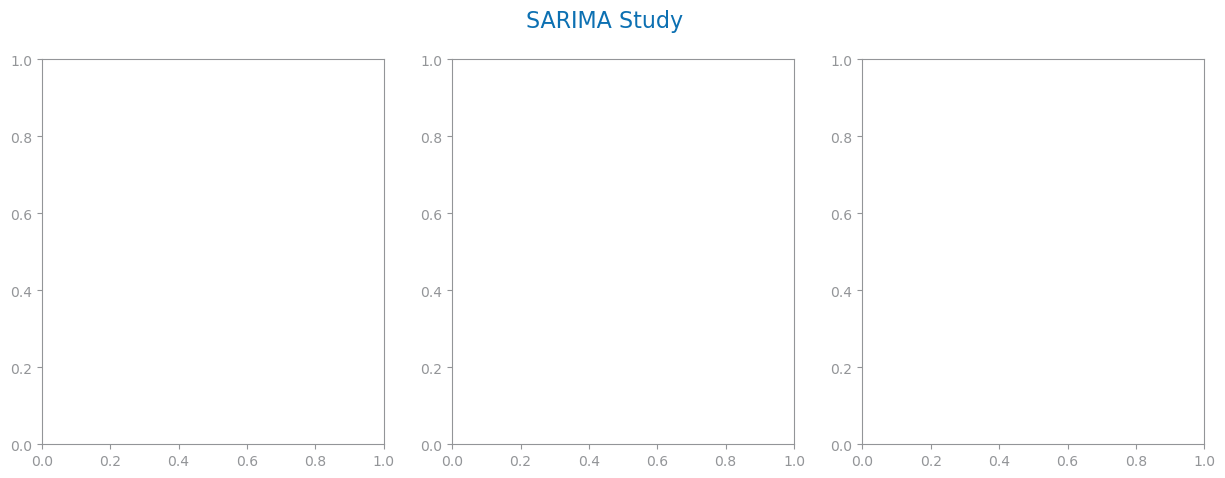

In [147]:
measure = 'R2'
best_model, best_params = sarima_uni_study(trnY, tstY, measure=measure)
savefig(f"images/{file_tag}_sarima_univariate_{measure}_study.png")

## SARIMA model creation

In [ ]:

# Fit final SARIMA model with best params
params = best_params["params"]
predictor = SARIMAX(trnY, order=(params[0], params[1], params[2]), seasonal_order=(params[3], params[4], params[5], params[6]))
model = predictor.fit()
print(model.summary())

## SARIMA diagnostics Plot

In [ ]:
# Diagnostics
model.plot_diagnostics(figsize=(10, 6))

## SARIMA Evaluate

In [ ]:
#
# Predictions
#prd_trn = model.predict(start=0, end=len(trnY) - 1)
#prd_tst = model.forecast(steps=len(tstY))
#prd_tst.index = tstY.index
#
#plot_single_model_evaluation(trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Univariate SARIMA Evaluation (p,d,q,P,D,Q,s)=({params})")
#savefig(f"images/{file_tag}_sarima_{measure}_univariate_eval.png")

In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))
prd_tst.index = test.index

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Univariate SARIMA Evaluate (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_univariate_eval.png")

## SARIMA Forecasting plot

In [ ]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - SARIMA Univariate Forecasting",
    xlabel='Date',
    ylabel=target,
)

# ARIMA Multi Variate

## ARIMA Multivariate Study

In [32]:
test_data=False
# test_data=False


file_tag = "Gira Bike"


train=pd.read_csv(f"data/df_gira_agg_2h_final_train.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"data/df_gira_agg_2h_final_test.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
target='target_station_load_rate'
# Se os dados já tiverem a frequência correta para cada dia (com todas as horas), 
# podemos apenas ajustar o índice para começar no horário correto.
#
#train.index = pd.date_range(start='2022-01-01 14:00', periods=len(train), freq='2H')
#test.index = pd.date_range(start='2023-02-14 16:00', periods=len(test), freq='2H')



test_split_threshold=0.9
# Prepare the training and testing data from dataframes with features and target
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]


from numpy import arange

# Ensure no data leakage
assert not set(train.index).intersection(set(test.index)), "Data leakage detected: Train and test sets overlap."


train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4878 entries, 2022-01-01 14:00:00 to 2023-02-14 14:00:00
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   temperature_2m                                               4878 non-null   float64
 1   rain_mm                                                      4878 non-null   float64
 2   wmo_weather_code                                             4878 non-null   float64
 3   wind_speed_10m                                               4878 non-null   float64
 4   is_holiday_lisbon                                            4878 non-null   float64
 5   target_station_status                                        4878 non-null   float64
 6   target_station_load_rate                                     4878 non-null   float64
 7   station_load_rate_ Rua do Arco Cego / Av. 

In [33]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import DataFrame
from numpy import isfinite
from statsmodels.tsa.arima.model import ARIMA
import warnings

def arima_multi_study(train: DataFrame, test: DataFrame, target: str, measure: str = "R2",freq: str = None):
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train).all(axis=1)]
    test = test[isfinite(test).all(axis=1)]

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq)
        test = test.asfreq(freq)


    trnY = train.pop(target)
    tstY = test.pop(target)
    trnX = train
    tstX = test

    d_values = (0, 1, 2)
    p_params = (1, 5, 7,12)
    q_params = (1, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    fig.suptitle(f"{file_tag} ARIMA Study", fontsize=16)  # Add subtitle over the charts   
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    arima = ARIMA(endog=trnY, exog=trnX, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 50})  # Increase the number of iterations
                    prd_tst = model.forecast(steps=len(tstY), exog=tstX)
                    eval: float = FORECAST_MEASURES[measure](tstY, prd_tst)
                    # print(f"ARIMA ({p}, {d}, {q})", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (p, d, q)
                        best_model = model
                    yvalues.append(eval)
                except Exception as e:
                    print(f"ARIMA ({p}, {d}, {q}) failed: {e}")
                    yvalues.append(None)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")


ARIMA best results achieved with (p,d,q)=(5, 1, 5) ==> measure=0.23


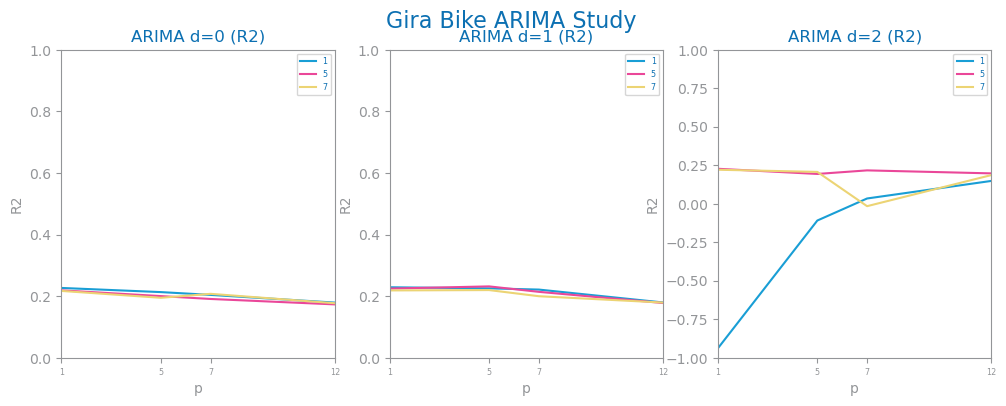

In [34]:

measure='R2'

best_model, best_params = arima_multi_study(train, test, target=target, measure=measure, freq=None)
savefig(f"images/{file_tag}_arima_multivariate_{measure}_study.png")

## ARIMA Multivariate Model

In [35]:
from statsmodels.tsa.arima.model import ARIMA

best_params["params"]

predictor = ARIMA(endog=trnY, exog=trnX, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())

                                  SARIMAX Results                                   
Dep. Variable:     target_station_load_rate   No. Observations:                 4878
Model:                       ARIMA(5, 1, 5)   Log Likelihood               -4688.122
Date:                      Mon, 24 Mar 2025   AIC                           9420.245
Time:                              00:23:52   BIC                           9563.075
Sample:                                   0   HQIC                          9470.368
                                     - 4878                                         
Covariance Type:                        opg                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
temperature_2m                                                  

## ARIMA Multivariate Plot Diagnostics

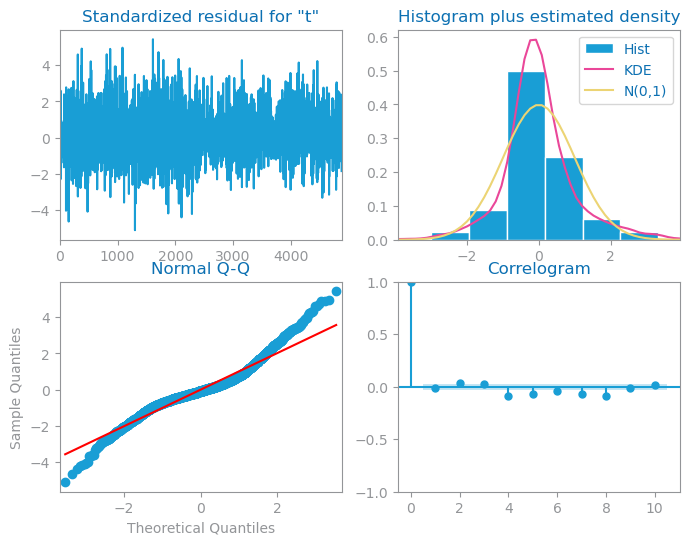

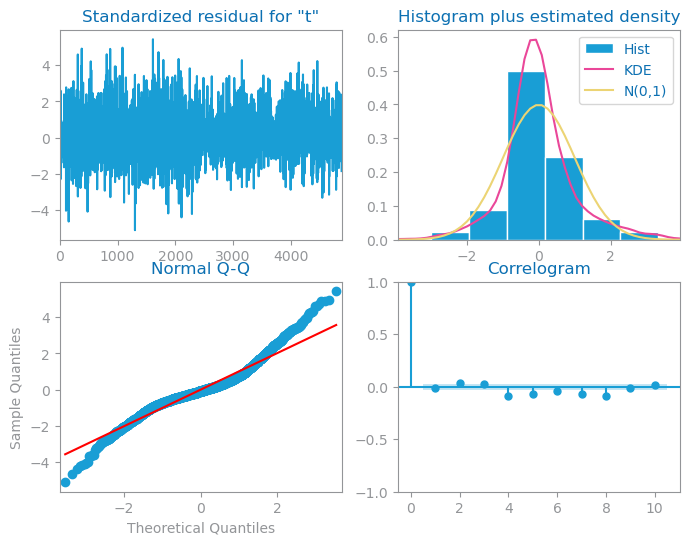

In [36]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Multivariate Evaluate

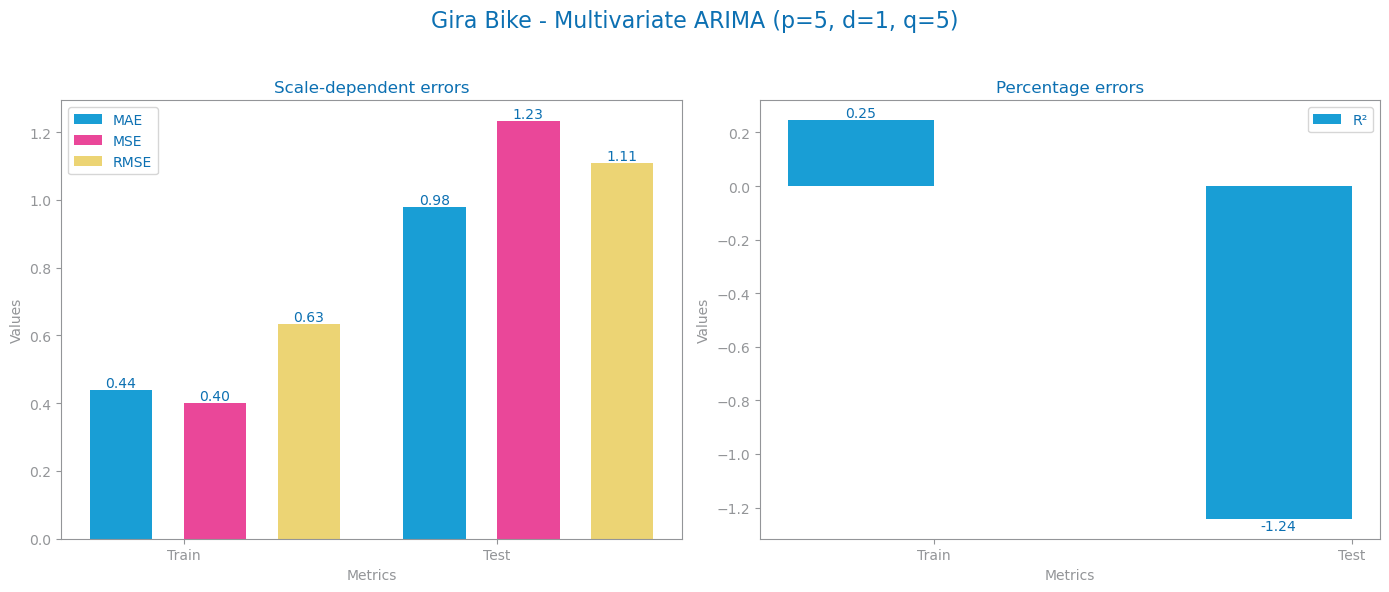

<Figure size 640x480 with 0 Axes>

In [38]:
from dslabs_functions import plot_forecasting_eval


params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)


# Use the last available exogenous variables from the training set for forecasting

last_exog = trnX.iloc[-1].values.reshape(1, -1)
exog_forecast = np.repeat(last_exog, len(test), axis=0)

#mean_exog = trnX.mean(axis=0).reshape(1, -1)  # Média das variáveis exógenas no conjunto de treino
#exog_forecast = np.repeat(mean_exog, len(test), axis=0)

prd_tst = best_model.forecast(steps=len(test), exog=exog_forecast)
prd_tst.index = test.index

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Multivariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_multivariate_eval.png")

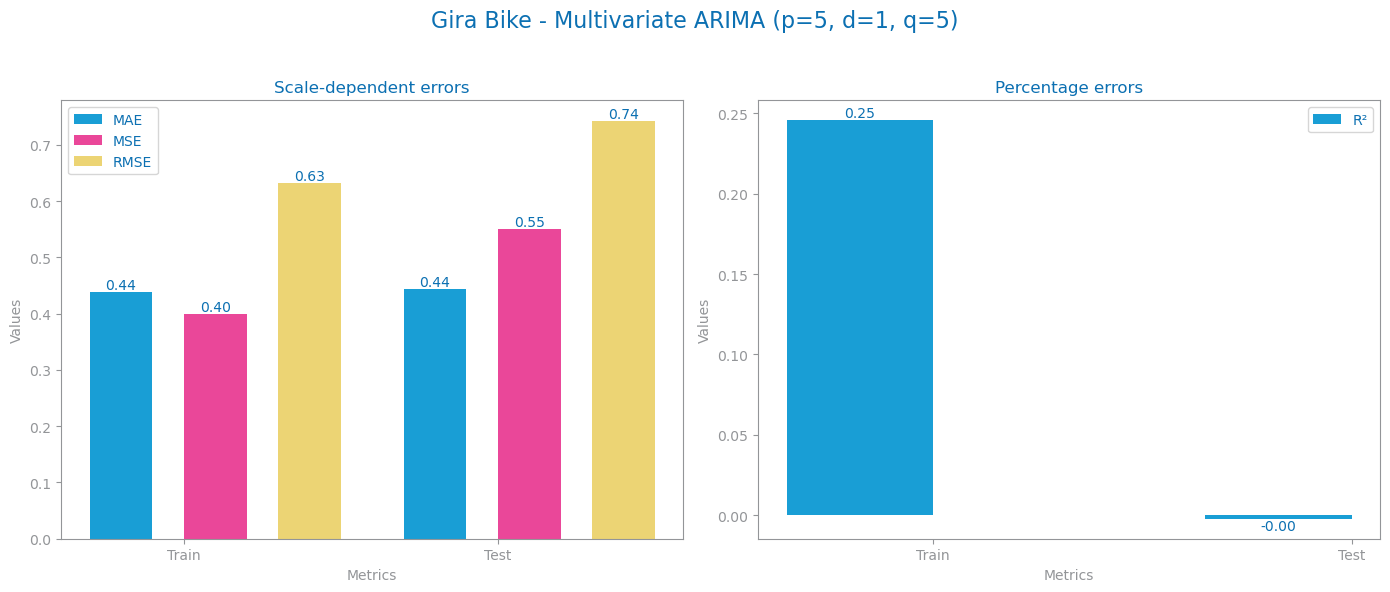

<Figure size 640x480 with 0 Axes>

In [ ]:
from dslabs_functions import plot_forecasting_eval


params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)


# Use the last available exogenous variables from the training set for forecasting

#last_exog = trnX.iloc[-1].values.reshape(1, -1)
#exog_forecast = np.repeat(last_exog, len(test), axis=0)

# Instead of using last value for each exog vairable, let's use the mean of the values of each exog mean from the training set for forecasting

mean_exog = trnX.mean(axis=0).values.reshape(1, -1)  # Converte a Series em NumPy array antes de aplicar reshape
exog_forecast = np.repeat(mean_exog, len(test), axis=0)

prd_tst = best_model.forecast(steps=len(test), exog=exog_forecast)
prd_tst.index = test.index

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Multivariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_multivariate_eval.png")


## ARIMA Multivariate Plot

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

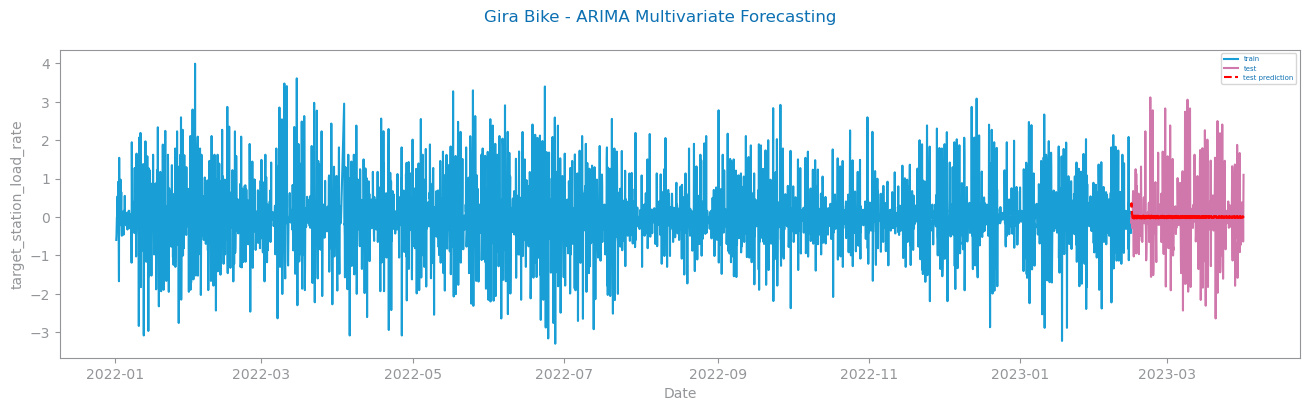

In [41]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Multivariate Forecasting",
    xlabel='Date',
    ylabel=target,
)

## Analysis - Results from Model Implementation

# TO DO:


    - É necessário definir FREQ? eu neste momento não estou a definir frequencia
    - No ARIMA univariate plot o prediction está outra vez a fazer em 1985, tenho que ver o que está a causar isto

-